In [1]:
using Revise
using CellBasedModels
using GLMakie
# using CairoMakie
using Random
using CUDA
Makie.inline!(true);

In [2]:
include("physiCell.jl");
include("utils.jl");

In [3]:
backgroundcolor = RGBf(239/255,239/255,239/255)

# Functions

In [4]:
function setupPhysiCell!(com, parameters=PhysiCell.parameters; init_volumes=false, ratio_volume_target = 2, init_ratio=true)

    for p in keys(parameters)
        if p in keys(com.parameters)
            com[p] .= parameters[p]
        end
    end

    if :vF in keys(com.parameters) #If cell model loaded
        if !init_volumes && any(PhysiCell.f_v.(com.vF,com.vNS,com.vCS) .≈ 0.)
            print("WARNING. Some cells have volume zero. Maybe you forgot to set them up. Set `init_volumes=true` if you want automatically setting up them with default parameters.")
        elseif init_volumes
            com.vNS .= parameters[:vNSTarget]/ratio_volume_target
            com.vCS .= PhysiCell.f_vCSTarget(parameters[:fCN],com.vNS)/ratio_volume_target
            com.vF .= parameters[:fF]*parameters[:v]/ratio_volume_target
        end
        if init_ratio && :r in keys(com.parameters)
            com.r .= PhysiCell.f_r.(com.vF,com.vNS,com.vCS)
        end
    end
        
end

setupPhysiCell! (generic function with 2 methods)

In [28]:
function evolveCustom!(com;steps,saveEach, preallocateAgents=0,verboseEach=100,verbose=false)
    loadToPlatform!(com, preallocateAgents = preallocateAgents) #Always necessary to load the parameters to the platform
    t = time()
    for i in 1:steps
        step!(com) #Always necessary to update the parameters at the end of all the steps.
        if verbose && i % verboseEach == 0
            println("Step ", i, " N: ",com.N, " Δt: ", time()-t)
            t = time()
        end
        if i % saveEach == 0
            saveRAM!(com)
        end
    end
    saveRAM!(com)
    bringFromPlatform!(com) #Always necessary to bring the data back to RAM after evolution lo unlock the agent.
end;

In [6]:
function plot_volume(com; size=(100,30), n=[1,2], stripe_size=5)

    d = getParameter(com,[:t,:id,:vF,:vCS,:vNS, :cycle])
    fig = Figure(size=size)
    ax = Axis(fig[1,1])
    for id in n
        ids = [id in i for i in d[:id]]
        pos = findfirst(d[:id][ids][1].==id)
        
        t = d[:t][ids]
        vNS = [i[pos] for i in d[:vNS][ids]]
        vCS = [i[pos] for i in d[:vCS][ids]]
        vF = [i[pos] for i in d[:vF][ids]]
        cycle = [i[pos] for i in d[:cycle][ids]]
        
        band!(ax,t,zeros(length(vNS)),vNS, color=:lightgreen)
        band!(ax,t,vNS,vNS.+vCS, color=:green)
        band!(ax,t,vNS.+vCS,vNS.+vCS.+vF, color=:orange)
        map = Dict(-1=>:gray,0=>:lightblue,1=>:blue,2=>:darkblue)
        band!(ax,t,-stripe_size .*ones(length(vNS)), 0 .*ones(length(vNS)), color=[map[i] for i in cycle])
    end

    return fig, ax
    
end

plot_volume (generic function with 1 method)

In [7]:
function plot_cells(com; times=[], show_ids=[], plane=[:x,:y], size=(400,400), alpha=(1,0.2,0.05), lims=nothing)

    if times == []
        times = [1, length(com)]
    end

    if show_ids == []
        show_ids = range(1,maximum(com.id))
    end
    
    d = getParameter(com,[:t,:x,:y,:z,:id,:vF,:vCS,:vNS])
    fig = Figure(size=(size[1],size[2]*length(times)))
    for (pos,time) in enumerate(times)
        if length(plane) == 2
            ax = Axis3(fig[pos,1], aspect = :data, azimuth=0.5*π, elevation=π/2, zlabelvisible=false, zticklabelsvisible=false)
        elseif length(plane) == 3
            ax = Axis3(fig[pos,1], aspect = :data)            
        else
            throw(Exception("Argument `plane` should be of size 2 or 3."))
        end
        ids = [i in show_ids for i in d[:id][time]]
        
        vNS = d[:vNS][time][ids]
        vCS = d[:vCS][time][ids]
        vF = d[:vF][time][ids]
        rN = PhysiCell.f_r.(vNS, 0., 0.)
        r = PhysiCell.f_r.(vNS, vCS, vF)
        x = d[plane[1]][time][ids]
        y = d[plane[2]][time][ids]
        rmax = maximum(r)

        if length(plane) == 2
            meshscatter!(ax, x, y, markersize=rN, color=(:black,alpha[1]))
            meshscatter!(ax, x, y, markersize=r, color=(:blue,alpha[2]))
            meshscatter!(ax, x, y, markersize=com.ra.*r, color=(:blue,alpha[3]))
        else
            z = d[plane[3]][time][ids]
            meshscatter!(ax, x, y, z, markersize=rN, color=(:black,alpha[1]))
            meshscatter!(ax, x, y, z, markersize=r, color=(:blue,alpha[2]))
            meshscatter!(ax, x, y, z, markersize=com.ra.*r, color=(:blue,alpha[3]))    
            if lims == nothing
                zlims!(ax, minimum(z)-com.ra[1]*rmax, maximum(z)+com.ra[1]*rmax)
            else
                zlims!(ax, lims[3,1], lims[3,2])#minimum(z)-com.ra[1]*rmax, maximum(z)+com.ra[1]*rmax)
        
            end
        end
        if lims == nothing
            xlims!(ax, minimum(x)-com.ra[1]*rmax, maximum(x)+com.ra[1]*rmax)
            ylims!(ax, minimum(y)-com.ra[1]*rmax, maximum(y)+com.ra[1]*rmax)
        else
            xlims!(ax, lims[1,1], lims[1,2])
            ylims!(ax, lims[2,1], lims[2,2])
        end
    end

    return fig
    
end

plot_cells (generic function with 1 method)

# Volume model & Cell Cycle models

In [8]:
for (name, cellCycleModel, cycle) in 
    [
        ("cellCycleAdvancedModel", PhysiCell.cellCycleAdvancedModel, 2),
        ("cellCycleAdvancedModelVariant1", PhysiCell.cellCycleAdvancedModelVariant1, 2),
        ("cellCycleAdvancedModelVariant2", PhysiCell.cellCycleAdvancedModelVariant2, 2),
        ("cellCycleBasicModel", PhysiCell.cellCycleBasicModel, 0),
        ("cellCycleBasicModelVariant1", PhysiCell.cellCycleBasicModelVariant1, 0),
        ("cellCycleBasicModelVariant2", PhysiCell.cellCycleBasicModelVariant2, 0),
        ("cellCycleLiveCellsModel", PhysiCell.cellCycleLiveCellsModel, 0),
    ]

    Random.seed!(0)
    model = ABM(3,
        baseModelInit = [
            PhysiCell.volumeModel,
            cellCycleModel,
            PhysiCell.cellDivisionModel
        ]
    );

    com = Community(model, N=1, dt=0.1)
    com.cycle = cycle
    setupPhysiCell!(com, init_volumes=true)

    evolve!(com, steps=500, preallocateAgents=9)
    com.N

    fig, ax = plot_volume(com, stripe_size=50)
    ax.title = name
    display(fig)

end

LoadError: BoundsError: attempt to access 0-element Vector{Vector{Int64}} at index [1]

# Death Models

WARNING. Some cells have volume zero. Maybe you forgot to set them up. Set `init_volumes=true` if you want automatically setting up them with default parameters.

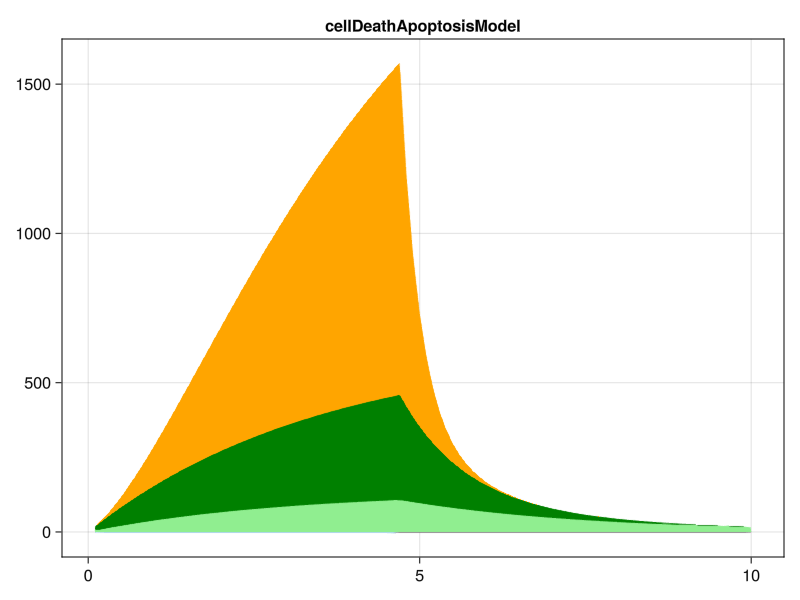

In [ ]:
for (name, cellDeathModel, cycle) in 
    [
        ("cellDeathApoptosisModel", PhysiCell.cellDeathApoptosisModel, 2),
    ]

    Random.seed!(0)
    model = ABM(3,
        baseModelInit = [
            PhysiCell.volumeModel,
            PhysiCell.cellCycleLiveCellsModel,
            PhysiCell.cellDivisionModel,
            cellDeathModel,
        ]
    );

    com = Community(model, N=1, dt=0.1)
    setupPhysiCell!(com)
    #Custom initialization    
    com.rDeathApop = 0.8
#    com.tApop = 100

    evolve!(com, steps=100, preallocateAgents=9)

    fig, ax = plot_volume(com, n=[1], stripe_size=5)
    ax.title = name
    display(fig)

end

# Mechanics

In [ ]:
include("physiCell.jl");
include("utils.jl");

## Cell interactions

In [ ]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.volumeModel,
        PhysiCell.cellMechanicsModelBegin,
        PhysiCell.cellMechanicsCellCellAdhesionModel,
        PhysiCell.cellMechanicsModelEnd
    ]
);

In [ ]:
com = Community(model,N=2,dt=0.1/60)

setupPhysiCell!(com, init_volumes=true)
com.rF = 0
com.rC = 0
com.rN = 0

com.x .= [-4.,4.]
com.vF

2-element Vector{Float64}:
 935.25
 935.25

In [ ]:
evolve!(com, steps=2000, preallocateAgents=100)

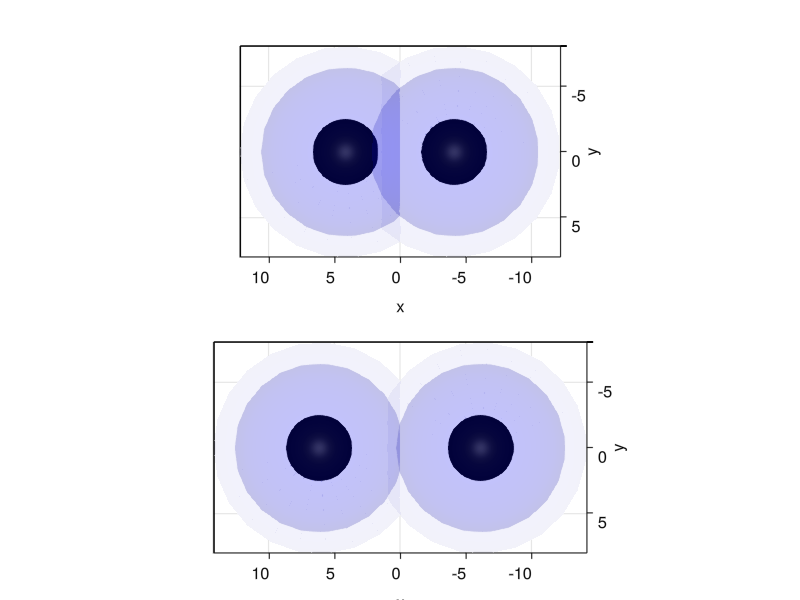

In [ ]:
plot_cells(com, plane=[:x,:y])

## Cell division

In [5]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.volumeModel,
        PhysiCell.cellCycleLiveCellsModel,
        PhysiCell.cellDivisionModel,
        PhysiCell.cellMechanicsModelBegin,
        PhysiCell.cellMechanicsCellCellAdhesionModel,
        PhysiCell.cellMechanicsModelEnd
    ],
    neighborsAlg=CBMNeighbors.CLVD(cellEdge=[10,10,10],skin=10,nMaxNeighbors=20),
    platform=GPU()
);

In [6]:
com = Community(model,N=1,dt=0.1/60, simBox=[-300 300;-300 300;-300 300])

setupPhysiCell!(com, init_volumes=true)

1-element Vector{Float64}:
 6.450471028290378

In [7]:
function evolveCustom!(com,steps,preallocateAgents)
    loadToPlatform!(com, preallocateAgents=preallocateAgents+2000) #Always necessary to load the parameters to the platform
    times = []
    n = []
    for i in 1:steps/1000
        t = @elapsed for j in 1:1000
            step!(com) #Always necessary to update the parameters at the end of all the steps.
        end
        println("Step ", i, " N: ",com.N, " Δt: ", t)
        if com.N >= preallocateAgents
            print(step)
            break
        end
        push!(times,t)
        push!(n, CUDA.@allowscalar com.N[1])
    end
    bringFromPlatform!(com) #Always necessary to bring the data back to RAM after evolution lo unlock the agent.

    return times, n
end;

In [8]:
times, sizes = evolveCustom!(com, 200000, 120000)

Step 1.0 N: 1 Δt: 6.955646552
Step 2.0 N: 1 Δt: 0.899289819
Step 3.0 N: 1 Δt: 0.864239982
Step 4.0 N: 1 Δt: 0.920214477
Step 5.0 N: 1 Δt: 0.836987585
Step 6.0 N: 1 Δt: 0.939150337
Step 7.0 N: 1 Δt: 0.855211551
Step 8.0 N: 1 Δt: 0.90942169
Step 9.0 N: 2 Δt: 0.869251249
Step 10.0 N: 2 Δt: 0.886288797
Step 11.0 N: 2 Δt: 0.895552082
Step 12.0 N: 2 Δt: 0.859937857
Step 13.0 N: 2 Δt: 0.921138441
Step 14.0 N: 2 Δt: 0.84295805
Step 15.0 N: 2 Δt: 0.928807342
Step 16.0 N: 3 Δt: 0.848432172
Step 17.0 N: 3 Δt: 0.904904553
Step 18.0 N: 4 Δt: 0.876301543
Step 19.0 N: 4 Δt: 0.880155007
Step 20.0 N: 4 Δt: 0.906507866
Step 21.0 N: 5 Δt: 0.857675701
Step 22.0 N: 5 Δt: 0.924291916
Step 23.0 N: 5 Δt: 0.840848452
Step 24.0 N: 6 Δt: 0.926259719
Step 25.0 N: 7 Δt: 0.859027928
Step 26.0 N: 7 Δt: 0.90835899
Step 27.0 N: 7 Δt: 0.876298969
Step 28.0 N: 7 Δt: 0.875332075
Step 29.0 N: 7 Δt: 0.90276896
Step 30.0 N: 7 Δt: 0.851400737
Step 31.0 N: 8 Δt: 0.945861127
Step 32.0 N: 8 Δt: 0.842230901
Step 33.0 N: 8 Δt: 0.

(Any[6.955646552, 0.899289819, 0.864239982, 0.920214477, 0.836987585, 0.939150337, 0.855211551, 0.90942169, 0.869251249, 0.886288797  …  15.744346345, 17.50456869, 19.670647796, 22.891069261, 26.197894867, 29.686930485, 33.837495805, 38.626945661, 44.244118398, 50.786445413], Any[1, 1, 1, 1, 1, 1, 1, 1, 2, 2  …  61007, 65497, 70368, 75742, 81503, 87504, 94099, 101246, 108822, 116901])

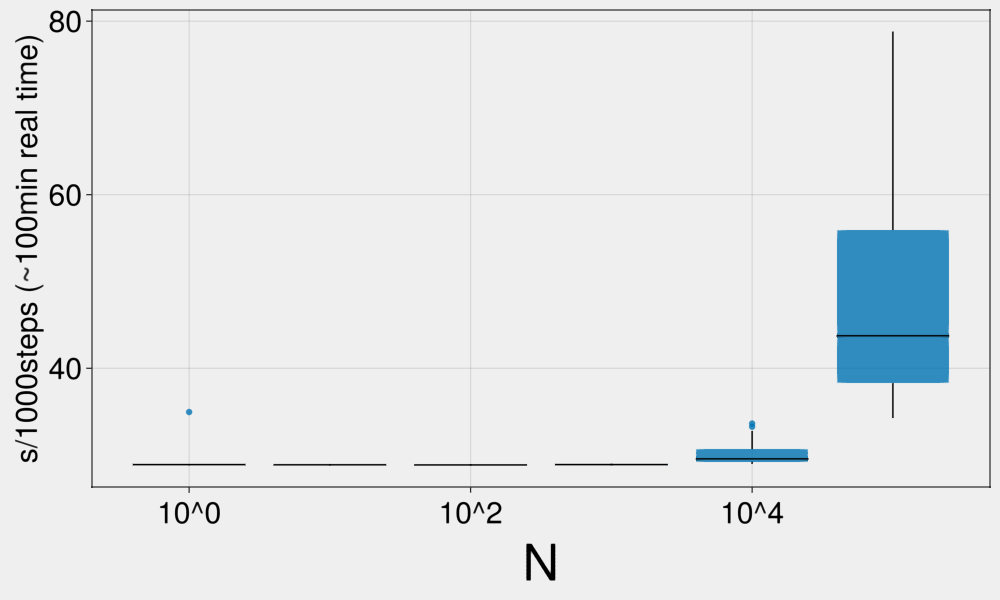

In [41]:
fig = Figure(size=(1000,600), backgroundcolor = RGBf(239/255,239/255,239/255), figure_padding = 10)
ax = Axis(fig[1,1], titlesize=50,
    xlabel="N", xlabelsize=50,
    ylabel="s/1000steps (~100min real time)", ylabelsize=30,
    xticklabelsize=30,
    yticklabelsize=30,
    xtickformat="10^{:.0f}",
    backgroundcolor = RGBf(239/255,239/255,239/255),
    # xscale = Makie.pseudolog10,
)

boxplot!(ax, round.(Int,log10.(sizes)), times .+ 28, width=1)

save("physicell_scaling.png", fig)

fig

In [10]:
#plot_cells(com, plane=[:x,:y,:z], alpha=(0,1,0), times=[1])

# Difussion

## Simulation Box

In [11]:
nsize=100
dx = 10.

10.0

## Make veins

In [12]:
# Define the branching rules and grid
max_depth = 500
base_branch_length = 1.0
sparsity = 0.04  # Probability to generate a new branch
n_branches = 4
stop_ratio = 0.999
persistence = 0.7  # Persistence factor for branch direction

# Initialize the root point and direction
root_point = [50, 50, 0.0]
initial_direction = [0.0, 0.0, 1.0]

# Generate the fractal tree
nodes = []; edges = []
for i in 0:2
    Random.seed!(i)
    nodes_, edges_ = generate_fractal_tree(root_point, initial_direction, 0, 
        max_depth=max_depth, base_branch_length=base_branch_length, 
        sparsity=sparsity, persistence=persistence, n_branches=n_branches, stop_ratio=stop_ratio)
    nodes = [nodes;nodes_]
end
# for j in 1:3
#     xmin = minimum([p[j] for p in nodes])
#     xmax = maximum([p[j] for p in nodes])
#     for (p,_) in enumerate(nodes)
#         nodes[p][j] = (nodes[p][j]-xmin)#/(xmax-xmin)
#     end
# end
nodes = [((i[1]+130)/2.5,(i[2])/1.5,(i[3]+130)/3) for i in nodes]
nodes = [nodes;[((100-i[2]),i[1],i[3]) for i in nodes];[((100-i[3]),(100-i[2]),(100-i[1])) for i in nodes]]
length(nodes)

50586

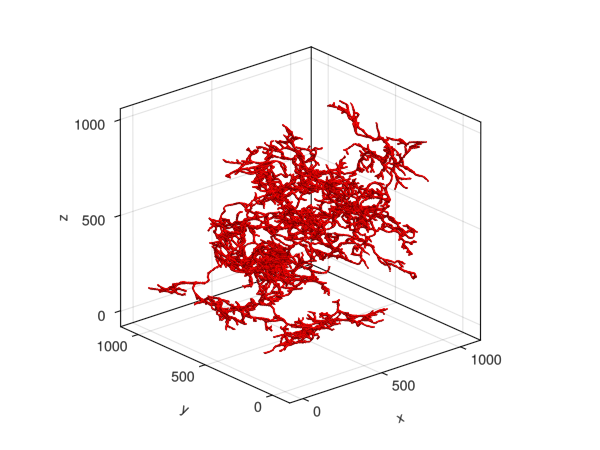

In [13]:
# Plot the tree using lines between nodes
fig = Figure()

ax = Axis3(fig[1,1], aspect=:data)
meshscatter!(ax,
    [dx*i[1] for i in nodes],
    [dx*i[2] for i in nodes],
    [dx*i[3] for i in nodes],
    color=:red,markersize=.5*dx)

# meshscatter!(ax,
#     [dx*(100-i[2]) for i in nodes],
#     [dx*i[1] for i in nodes],
#     [dx*i[3] for i in nodes],
#     color=:red,markersize=.5*dx)

# meshscatter!(ax,
#     [dx*(100-i[3]) for i in nodes],
#     [dx*(100-i[2]) for i in nodes],
#     [dx*(100-i[1]) for i in nodes],
#     color=:red,markersize=.5*dx)

fig

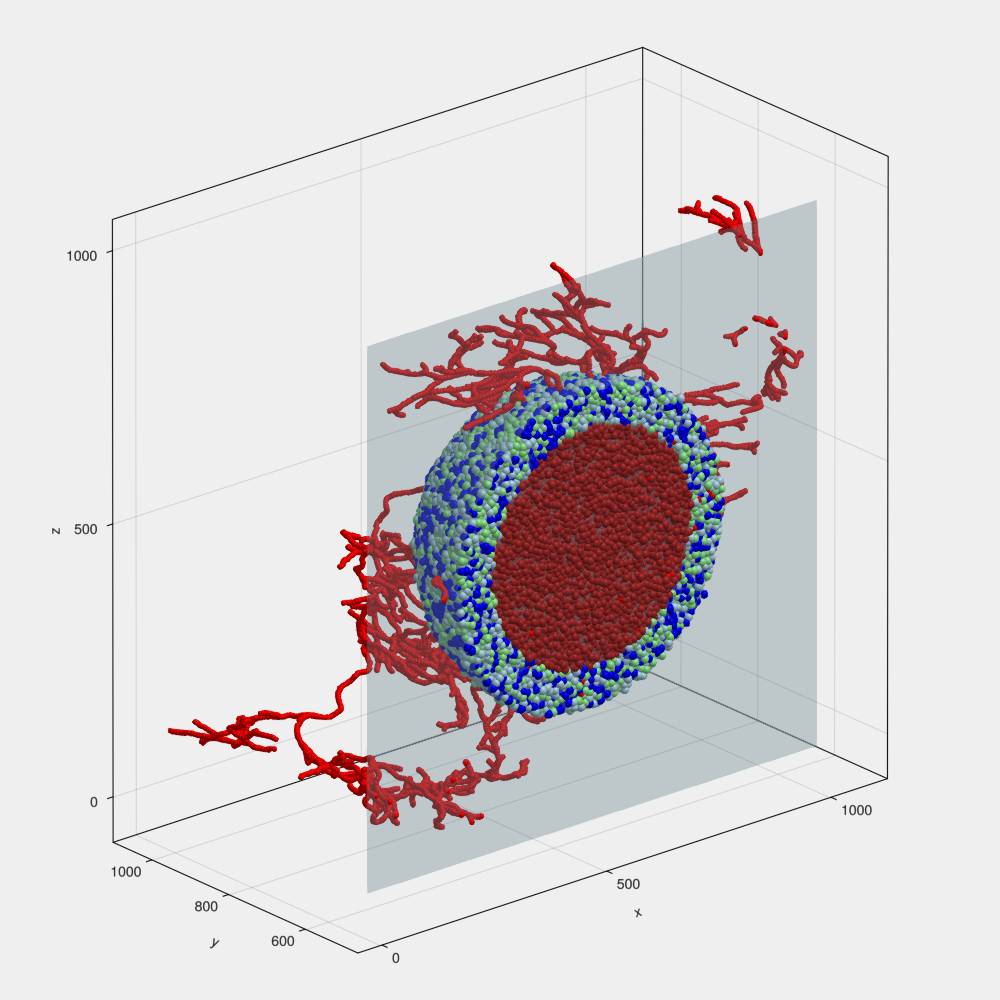

In [22]:
fig = Figure(size=(1000,1000), backgroundcolor=backgroundcolor, show_axis=false)

ax = Axis3(fig[1,1], aspect = :data)
mesh!(ax, Rect3f(Point3f(0, dx*50, 00), Vec3f(dx*100, 0, dx*100)), color = (:lightblue, 0.2), transparency=true)
meshscatter!(ax,[dx*i[1] for i in nodes if i[2]>50],[dx*i[2] for i in nodes if i[2]>50],[dx*i[3] for i in nodes if i[2]>50],color=:red,markersize=dx*0.5)
colsize!(fig.layout, 1, Aspect(1, 1))

vNS = com.vNS
vCS = com.vCS
vF = com.vF
rN = PhysiCell.f_r.(vNS, 0., 0.)
r = PhysiCell.f_r.(vNS, vCS, vF)
x = com.x .+500
y = com.y .+500
z = com.z .+500
color = rand([:lightgreen,:lightblue,:blue], length(z))
keep = sqrt.(com.x.^2+com.y.^2+com.z.^2) .< 220
color[keep] .= :brown
keep = com.y .> 0

meshscatter!(ax,x[keep],y[keep],z[keep],markersize=r[keep],color=color[keep])

resize_to_layout!(fig)
save("image.png",fig)

fig

## Model

In [37]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.mediumCO2,
        PhysiCell.mediumCO2Newmann
    ],

    mediumAlg = CBMIntegrators.DGADI(difussionCoefs=(co2=:Dco2,)),
    platform=GPU()
);

In [38]:
dt = 0.01
steps = 200

200

In [39]:
com = Community(model, dt=dt, simBox=[0 dx*nsize;0 dx*nsize;0 dx*nsize], NMedium=[nsize,nsize,nsize])
setupPhysiCell!(com,PhysiCell.parameters)

for (i,j,k) in nodes
    try
        com.veins[round(Int,i),round(Int,j),round(Int,k)] = 1.
    catch
        nothing
    end
end

In [40]:
evolveCustom!(com,steps=1000,saveEach=999)

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f74cad5b530.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/GMsgk/src/GPUArraysCore.jl:149


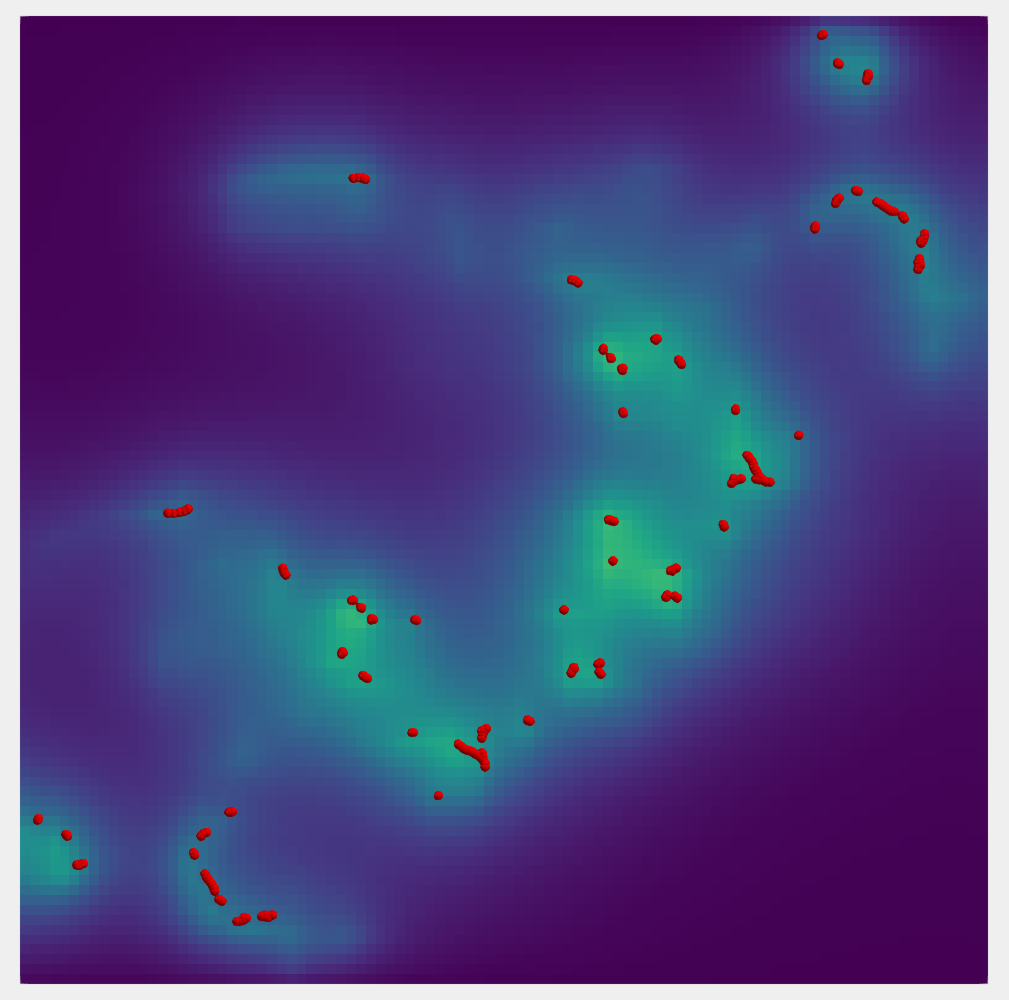

In [33]:
fig = Figure(size=(1000,1000), backgroundcolor=backgroundcolor, show_axis=false)

# ax = Axis3(fig[1,1], aspect = :data)
# mesh!(ax, Rect3f(Point3f(0, dx*50, 00), Vec3f(dx*100, 0, dx*100)), color = (:lightblue, 0.4), transparency=true)
# meshscatter!(ax,[dx*i[1] for i in nodes],[dx*i[2] for i in nodes],[dx*i[3] for i in nodes],color=:red,markersize=dx*0.5)
# colsize!(fig.layout, 1, Aspect(1, 1))

ax = Axis(fig[1,1])
heatmap!(ax,range(2,dx*nsize-1,length=nsize),range(2,dx*nsize-1,length=nsize),com.co2[2:end-1,50,2:end-1], colorrange=(0,maximum(com.co2)))
keep = [round(Int,i[2])==50 for i in nodes]
meshscatter!(ax,[dx*i[1] for i in nodes[keep]],[dx*i[3] for i in nodes[keep]],color=:red,markersize=dx*0.5)
#heatmap!(ax,setMask.(com.veins[:,:,50]), colorrange=(0,1), alpha=1, colormap=:reds)
colsize!(fig.layout, 1, Aspect(1, 1))

resize_to_layout!(fig)
save("field.png",fig)

hidedecorations!(ax)
hidespines!(ax)

fig

## Venous system without plane

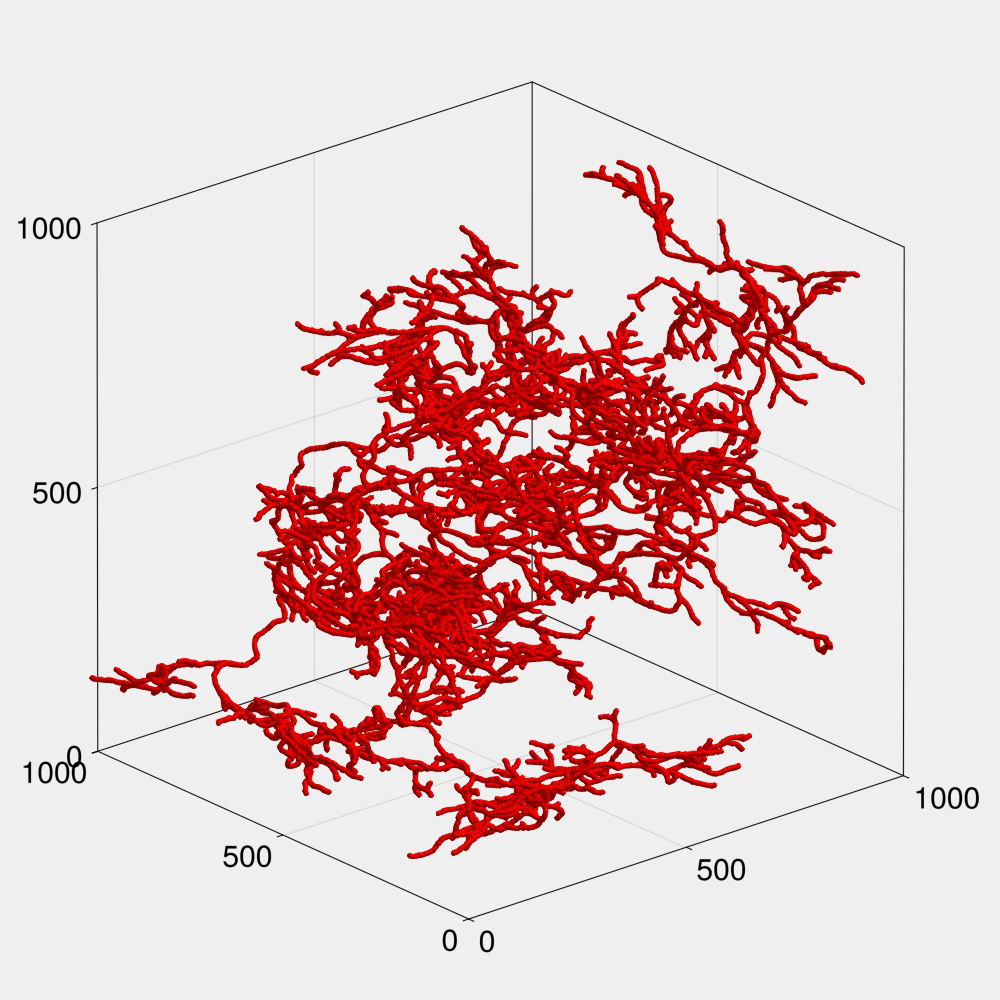

In [26]:
fig = Figure(size=(1000,1000), backgroundcolor=backgroundcolor, show_axis=false, figure_padding = 50)

ax1 = Axis3(fig[1,1], aspect = :data,
    xlabelsize=0,
    ylabelsize=0,
    zlabelsize=0,
    xticklabelsize=30,
    yticklabelsize=30,
    zticklabelsize=30
)

meshscatter!(ax1,[dx*i[1] for i in nodes],[dx*i[2] for i in nodes],[dx*i[3] for i in nodes],color=:red,markersize=dx*0.5)
colsize!(fig.layout, 1, Aspect(1, 1))
xlims!(ax1,0,dx*nsize)
ylims!(ax1,0,dx*nsize)
zlims!(ax1,0,dx*nsize)

resize_to_layout!(fig)

save("veins.png",fig)

fig


## Venous system with plane

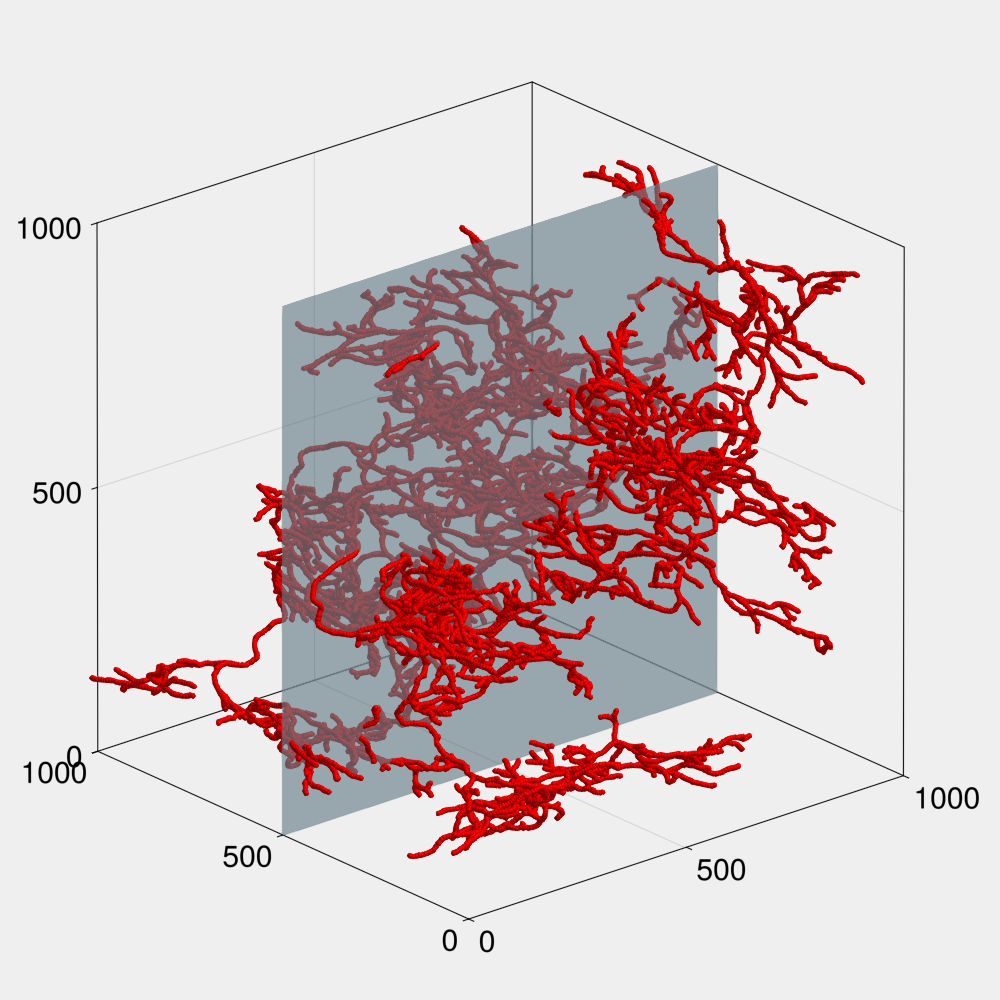

In [27]:
fig = Figure(size=(1000,1000), backgroundcolor=backgroundcolor, show_axis=false, figure_padding = 50)

ax1 = Axis3(fig[1,1], aspect = :data, 
xlabelsize=0,
ylabelsize=0,
zlabelsize=0,
xticklabelsize=30,
yticklabelsize=30,
zticklabelsize=30
)

mesh!(ax1, Rect3f(Point3f(0, dx*50, 00), Vec3f(dx*100, 0, dx*100)), color = (:lightblue, 0.4), transparency=true)
meshscatter!(ax1,[dx*i[1] for i in nodes],[dx*i[2] for i in nodes],[dx*i[3] for i in nodes],color=:red,markersize=dx*0.5)
colsize!(fig.layout, 1, Aspect(1, 1))
xlims!(ax1,0,dx*nsize)
ylims!(ax1,0,dx*nsize)
zlims!(ax1,0,dx*nsize)

resize_to_layout!(fig)

save("veins_plane.png",fig)

fig


## Video of diffusion

In [28]:
# Start
com = Community(model, dt=0.01, simBox=[0 dx*nsize;0 dx*nsize;0 dx*nsize], NMedium=[nsize,nsize,nsize])
setupPhysiCell!(com,PhysiCell.parameters)

for (i,j,k) in nodes
    try
        com.veins[round(Int,i),round(Int,j),round(Int,k)] = 1.
    catch
        nothing
    end
end

# Video
fig = Figure(size=(1000,1000), backgroundcolor=backgroundcolor, show_axis=false, figure_padding = 50)

ax = Axis(fig[1,1],
    xlabelsize=0,
    ylabelsize=0,
    xticklabelsize=0,
    yticklabelsize=0,
    xticksize=0,
    yticksize=0,
)

hm_data = Observable(com.co2[2:end-1,50,2:end-1])
hm = heatmap!(ax,range(2,dx*nsize-1,length=nsize),range(2,dx*nsize-1,length=nsize),hm_data, colorrange=(0,com.co2saturation[1]/(1+com.λco2[1])))
keep = [round(Int,i[2])==50 for i in nodes]
meshscatter!(ax,[dx*i[1] for i in nodes[keep]],[dx*i[3] for i in nodes[keep]],color=:red,markersize=dx*0.5)
colsize!(fig.layout, 1, Aspect(1, 1))

resize_to_layout!(fig)

GLMakie.record(fig, "animation.gif", 0:200; framerate = 12) do iter

    evolveCustom!(com,steps=1,saveEach=1000)

    hm_data[] = com.co2[2:end-1,50,2:end-1]

end

"animation.gif"

# Add Cells

In [34]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.volumeModel,
        PhysiCell.cellCycleAdvancedModel,
        PhysiCell.cellDivisionModel,
        PhysiCell.cellMechanicsModelBegin,
        PhysiCell.cellMechanicsCellCellAdhesionModel,
        PhysiCell.cellMechanicsModelEnd,
        PhysiCell.mediumCO2,
        PhysiCell.mediumCO2Newmann
    ],

    neighborsAlg = CBMNeighbors.CLVD(cellEdge=[10,10,10],skin=10,nMaxNeighbors=20),

    mediumAlg = CBMIntegrators.DGADI(difussionCoefs=(co2=:Dco2,)),

    platform=GPU()
);

In [35]:
com = Community(model, N=1, dt=0.1/60, simBox=[0 dx*nsize;0 dx*nsize;0 dx*nsize], NMedium=[nsize,nsize,nsize])
setupPhysiCell!(com,PhysiCell.parameters, init_volumes=true)

r = PhysiCell.f_r.(com.vNS, com.vCS, com.vF)[1]

f(x) = sqrt((x[1]-500)^2+(x[2]-500)^2+(x[3]-500)^2)<500
x,y,z = CellBasedModels.CBMUtils.initializeSpheres([400 600;400 600;400 600],r;fExtrude=f)#sqrt((x[1])^2+(x[2])^2+(x[3])^2)<3)

com = Community(model, N=length(x), dt=0.1/60, simBox=[0 dx*nsize;0 dx*nsize;0 dx*nsize], NMedium=[nsize,nsize,nsize])
setupPhysiCell!(com,PhysiCell.parameters, init_volumes=true)
s = length(z)
com.x .= x.+r .*(rand(s).-.5)*2
com.y .= y.+r .*(rand(s).-.5)*2
com.z .= z.+r .*(rand(s).-.5)*2
color=rand([:green,:lightblue,:blue],s)

length(z)

2739

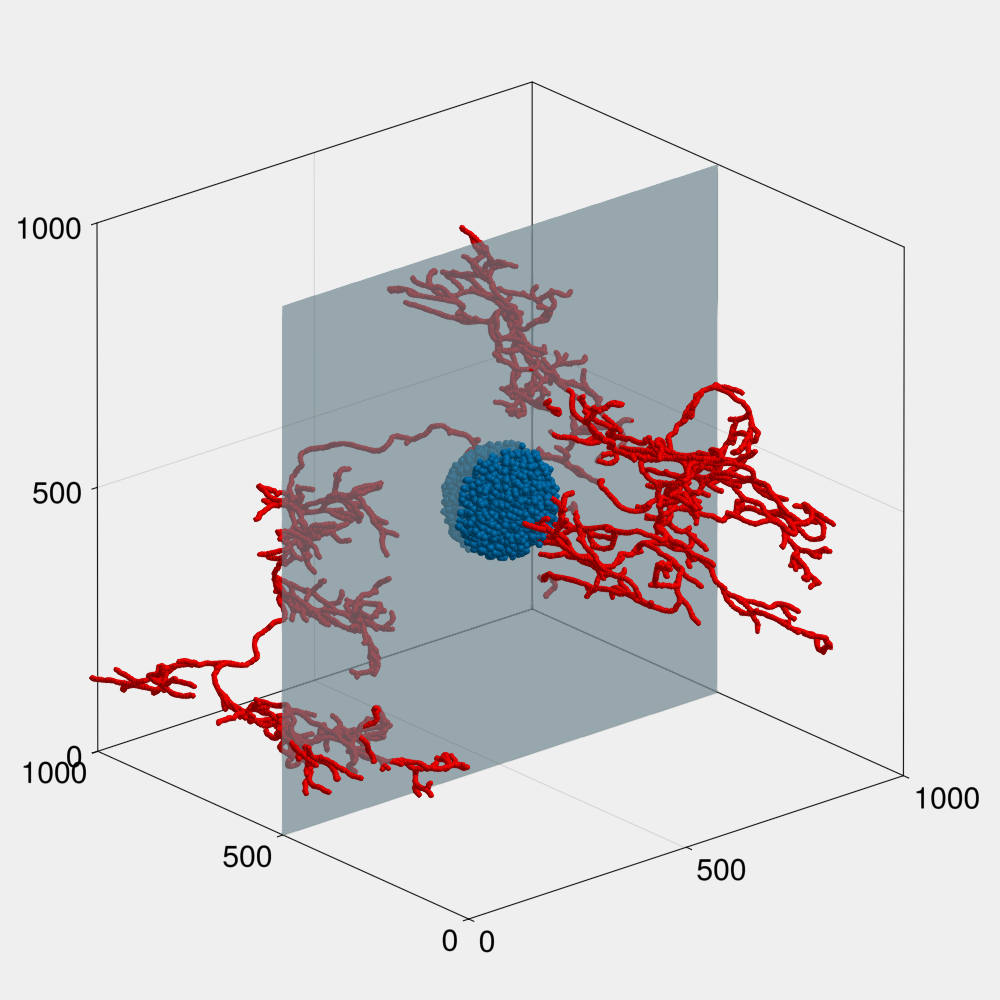

In [36]:
fig = Figure(size=(1000,1000), backgroundcolor=backgroundcolor, show_axis=false, figure_padding = 50)

ax1 = Axis3(fig[1,1], aspect = :data, 
    xlabelsize=0,
    ylabelsize=0,
    zlabelsize=0,
    xticklabelsize=30,
    yticklabelsize=30,
    zticklabelsize=30
)

mesh!(ax1, Rect3f(Point3f(0, dx*50, 00), Vec3f(dx*100, 0, dx*100)), color = (:lightblue, 0.4), transparency=true)
meshscatter!(ax1,[dx*i[1] for i in nodes],[dx*i[2] for i in nodes],[dx*i[3] for i in nodes],color=:red,markersize=dx*0.5)
colsize!(fig.layout, 1, Aspect(1, 1))
xlims!(ax1,0,dx*nsize)
ylims!(ax1,0,dx*nsize)
zlims!(ax1,0,dx*nsize)

x = com.x
y = com.y
z = com.z
r = PhysiCell.f_r.(com.vNS, com.vCS, com.vF)
meshscatter!(ax1,x,y,z,markersize=r)

resize_to_layout!(fig)

save("veins_plane_cells.png",fig)

fig

In [37]:
evolveCustom!(com, steps=1000, saveEach=20000, preallocateAgents=5000, verbose=true, verboseEach=1000)

LoadError: MethodError: no method matching (::var"#kernel#176")(::CuDeviceArray{Float32, 4, 1}, ::CuDeviceArray{Float32, 4, 1}, ::Float64, ::Float64, ::Int64, ::CuDeviceVector{Int64, 1}, ::Int64, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceMatrix{Float32, 1}, ::Float64, ::Float64, ::Float64, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::Int64, ::Int64, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceMatrix{Int64, 1}, ::CuDeviceMatrix{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Bool, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceArray{Float32, 3, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Bool, 1}, ::CuDeviceVector{Float32, 1}, ::CuDeviceVector{Int64, 1}, ::CuDeviceVector{Float32, 1})

[0mClosest candidates are:
[0m  (::var"#kernel#176")(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m)
[0m[90m   @[39m [32mMain[39m [90m~/Documents/CellBasedModels.jl/src/AgentStructure/[39m[90m[4mfunctionDE.jl:95[24m[39m


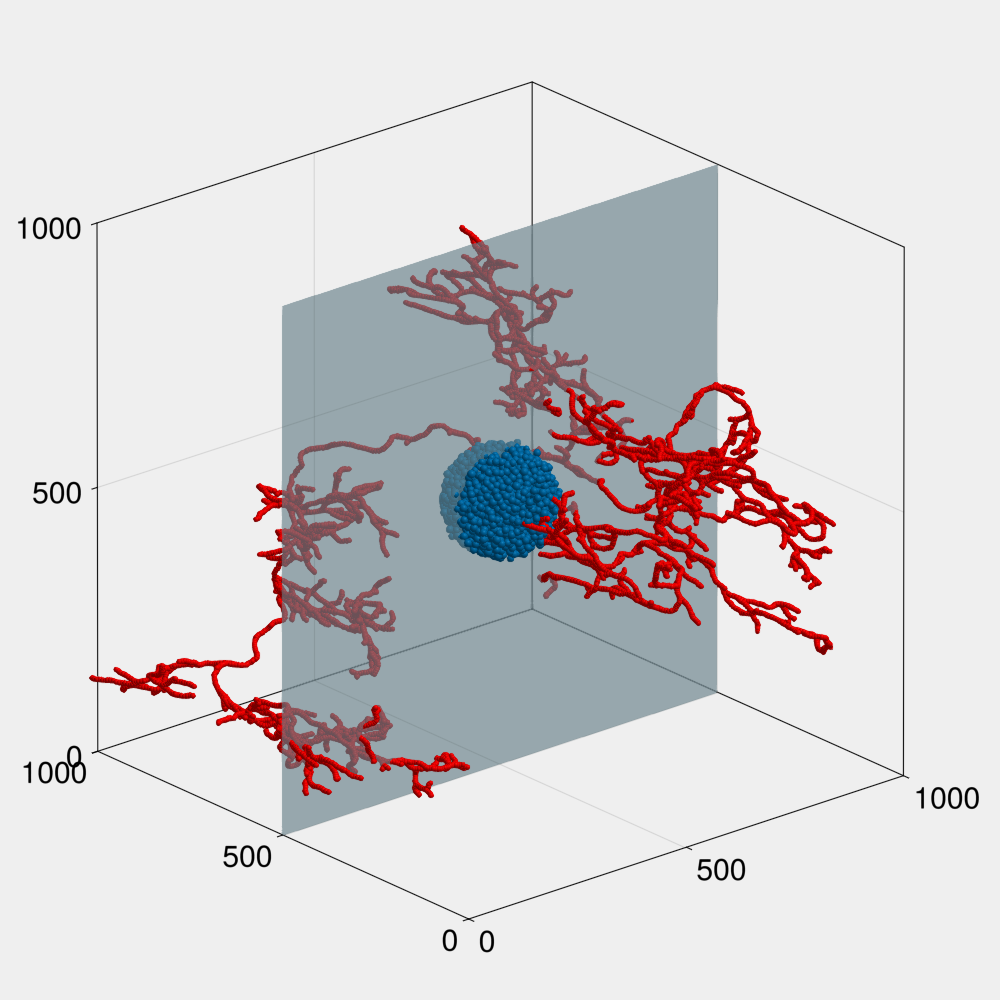

In [33]:
fig = Figure(size=(1000,1000), backgroundcolor=backgroundcolor, show_axis=false, figure_padding = 50)

ax1 = Axis3(fig[1,1], aspect = :data, 
    xlabelsize=0,
    ylabelsize=0,
    zlabelsize=0,
    xticklabelsize=30,
    yticklabelsize=30,
    zticklabelsize=30
)

mesh!(ax1, Rect3f(Point3f(0, dx*50, 00), Vec3f(dx*100, 0, dx*100)), color = (:lightblue, 0.4), transparency=true)
meshscatter!(ax1,[dx*i[1] for i in nodes],[dx*i[2] for i in nodes],[dx*i[3] for i in nodes],color=:red,markersize=dx*0.5)
colsize!(fig.layout, 1, Aspect(1, 1))
xlims!(ax1,0,dx*nsize)
ylims!(ax1,0,dx*nsize)
zlims!(ax1,0,dx*nsize)

x = com.x
y = com.y
z = com.z
r = PhysiCell.f_r.(com.vNS, com.vCS, com.vF)
meshscatter!(ax1,x,y,z,markersize=r)

resize_to_layout!(fig)

save("veins_plane_cells.png",fig)

fig